In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
import torch.nn.functional as F
import pandas as pd
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import r2_score, mean_squared_error
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
start = 1
data = pd.read_csv("data-B90102-30m.csv")
room = data["room_temp"]
airflow = data["airflow_cur"]
supply = data["supply_temp"]

In [ ]:
delta =  np.array(room[start:-1]) - np.array(room[start-1:-2])
delta_supply = np.array(supply[start+1:]) - np.array(supply[start:-1])
delta_air = np.array(airflow[start+1:]) - np.array(airflow[start:-1])

temp_cur = np.array(room[start:-1]).reshape(-1,1)
temp = np.array(room[start-1:-1-1]).reshape(-1,1)
output = np.array(room[start+1:]).reshape(-1,1)
air = np.array(airflow[start:-1]).reshape(-1,1)
supply = np.array(supply[start:-1]).reshape(-1,1)

air_origin = torch.tensor(air).to(device).reshape(-1,1).float()
supply_origin = torch.tensor(supply).to(device).reshape(-1,1).float()
temp_origin = torch.tensor(temp).to(device).reshape(-1,1).float()
output_origin = torch.tensor(output).to(device).reshape(-1,1).float()
temp_cur = torch.tensor(temp_cur).to(device).reshape(-1,1).float()

delta = torch.tensor(delta).reshape(-1,1).float().to(device)/(max(temp_origin) - min(temp_origin))
delta_supply = torch.tensor(delta_supply).reshape(-1,1).float().to(device)/(max(supply_origin) - min(supply_origin))
delta_air = torch.tensor(delta_air).reshape(-1,1).float().to(device)/(max(air_origin)- min(air_origin))

delta = torch.concat((delta, delta_supply, delta_air), dim =1)

In [ ]:
air = (air_origin - min(air_origin))/(max(air_origin)- min(air_origin))
air = air.requires_grad_(True)
supply = (supply_origin - min(supply_origin))/(max(supply_origin) - min(supply_origin))
supply = supply.requires_grad_(True)
temp = (temp_origin - min(temp_origin))/(max(temp_origin) - min(temp_origin))
temp = temp.requires_grad_(True)
output = (output - min(output))/(max(output) - min(output))
output = torch.tensor(output).reshape(-1,1).float().to(device)
temp_cur = (temp_cur - min(temp_origin))/(max(temp_origin) - min(temp_origin))

In [ ]:
def data_split(N: int, N_end: int, temp_cur: torch.Tensor, temp: torch.Tensor, supply: torch.Tensor, air: torch.Tensor, output: torch.Tensor, delta: torch.Tensor):
    temp_cur_tr = temp_cur[N:N_end]
    temp_tr = temp[N:N_end]
    supply_tr = supply[N:N_end]
    air_tr = air[N:N_end]
    output_tr = output[N:N_end]
    delta_tr = delta[N:N_end].requires_grad_(True)
    return temp_cur_tr, temp_tr, supply_tr, air_tr, output_tr, delta_tr

In [ ]:
class Taylor_Mono_Net(nn.Module):
    def __init__(self, n=1):
        super(Taylor_Mono_Net, self).__init__()
        self.n = n
        self.fc1 = nn.Linear(3, 3*self.n)
        self.fc2_1 = nn.Linear(1*self.n, 1)
        self.fc2_2 = nn.Linear(1*self.n, 1)
        self.fc2_3 = nn.Linear(1*self.n, 1)

    def forward(self, x, y, z):
        x = torch.cat((x, y, z), dim=1)
        x = F.relu(self.fc1(x))
        x_1 = self.fc2_1(x[:, 0:1*self.n].reshape(-1, 1*self.n))
        y_1 = F.softplus(self.fc2_2(x[:, 1*self.n:2*self.n].reshape(-1, 1*self.n)))
        z_1 = self.fc2_3(x[:, 2*self.n:3*self.n].reshape(-1, 1*self.n))
        x = torch.cat((x_1, y_1, z_1), dim=1)
        return x

n_value = 1
model_Taylor_Mono = Taylor_Mono_Net(n=n_value).to(device)

In [ ]:
class Taylor_Net(nn.Module):
    def __init__(self, n=1):
        super(Taylor_Net, self).__init__()
        self.n = n
        self.fc1 = nn.Linear(3, 3*self.n)
        self.fc2_1 = nn.Linear(self.n, 1)
        self.fc2_2 = nn.Linear(self.n, 1)
        self.fc2_3 = nn.Linear(self.n, 1)

    def forward(self, x, y, z):
        x = torch.cat((x, y, z), dim=1)
        x = F.relu(self.fc1(x))
        x_1 = self.fc2_1(x[:, 0:self.n].reshape(-1, self.n))
        y_1 = self.fc2_2(x[:, self.n:2*self.n].reshape(-1, self.n))
        z_1 = self.fc2_3(x[:, 2*self.n:3*self.n].reshape(-1, self.n))
        x = torch.cat((x_1, y_1, z_1), dim=1)
        return x

n_value = 1
model_Taylor = Taylor_Net(n=n_value).to(device)


In [ ]:
def train_model(model, optimizer, criterion, temp_cur_tr, temp_tr, supply_tr, air_tr, output_temp_tr, delta_tr, scheduler=None, epochs=20000, patience=1000, threshold=1e-10, print_interval=5000):
    prev_loss = float('inf')
    no_improvement_counter = 0
    loss_array = []
    r2_array = []
    point = []
    for epoch in range(epochs):
        model.train()  
        optimizer.zero_grad()

        elementwise_product = torch.mul(model(temp_tr, supply_tr, air_tr), delta_tr) 
        dot_products = torch.sum(elementwise_product, dim=1, keepdim=True)
        output = temp_cur_tr + dot_products
        loss = criterion(output, output_temp_tr)
        loss_array.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        if scheduler:
            scheduler.step()
        if epoch % 50 == 0:
            loss_array.append(loss.item())
            r2_score_tr = r2_score(output_temp_tr.to("cpu").detach().numpy(), output.to("cpu").detach().numpy())
            r2_array.append(r2_score_tr)
            point.append(epoch // 50)
        if epoch % print_interval == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.9f}')
        if abs(prev_loss - loss.item()) < threshold:
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0  
        prev_loss = loss.item()
        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no significant improvement.')
            break
        if loss.item() < 0.00000087022:
            print(f'Early stopping at epoch {epoch+1} due to very low loss.')
            print("min of loss function is", min(loss_array))
            break
    return loss.item()

In [ ]:
def calculate_next(model, temp_cur__t, temp__t, supply__t, air__t, delta__t):
    elementwise_product__t = torch.mul(model(temp__t, supply__t, air__t), delta__t)
    dot_products__t = torch.sum(elementwise_product__t, dim=1, keepdim=True)
    output__t = temp_cur__t + dot_products__t
    return output__t

In [ ]:

epochs = 25000
patience = 1000
threshold = 1e-15
decay_factor = 1.0  
decay_step_size = 1000  

N_start, N_end = 360, 540
Ns__t, Ne__t = 950, 1050
Ns_val, Ne_val = 800, 900
temp_cur_tr, temp_tr, supply_tr, air_tr, output_tr, delta_tr = data_split(N_start, N_end, temp_cur, temp, supply, air, output, delta)
temp_cur__t, temp__t, supply__t, air__t, output__t, delta__t = data_split(Ns__t, Ne__t, temp_cur, temp, supply, air, output, delta)

temp_cur_val, temp_val, supply_val, air_val, output_val, delta_val = data_split(Ns_val, Ne_val, temp_cur, temp, supply, air, output, delta)

In [ ]:
def evaluate_model_1(model_path, model_class, num_predict, device='cpu'):
    r2_loop = []
    output_loop = []
    real_loop = []
    model = model_class(n=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    t_next = calculate_next(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
    r2 = r2_score(output__t[:-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    output_loop.append(t_next.to("cpu").detach().numpy())
    real_loop.append(output__t[:-num_predict].to("cpu").detach().numpy())
    
    thresh = 1
    delta = t_next - temp_cur__t[0:-num_predict]
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[1:1-num_predict, 1].reshape(-1,1), delta__t[1:1-num_predict, 2].reshape(-1,1)), dim = 1)
    
    t_next_2 = calculate_next(model, t_next, temp__t[1:1-num_predict], supply__t[1:1-num_predict], air__t[1:1-num_predict], delta)
    r2 = r2_score(output__t[1:1-num_predict].to("cpu").detach().numpy(), t_next_2.to("cpu").detach().numpy())
    r2_loop.append(r2)
    output_loop.append(t_next_2.to("cpu").detach().numpy())
    real_loop.append(output__t[1:1-num_predict].to("cpu").detach().numpy())
    delta = t_next_2 - t_next
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[2:2-num_predict, 1].reshape(-1,1), delta__t[2:2-num_predict, 2].reshape(-1,1)), dim = 1)
    
    for i in range(2, num_predict):
        t_next_3 = calculate_next(model, t_next_2, t_next, supply__t[i:i-num_predict], air__t[i:i-num_predict], delta)
        r2 = r2_score(output__t[i:i-num_predict].to("cpu").detach().numpy(), t_next_3.to("cpu").detach().numpy())
        r2_loop.append(r2)
        output_loop.append(t_next_3.to("cpu").detach().numpy())
        real_loop.append(output__t[i:i-num_predict].to("cpu").detach().numpy())
        delta = t_next_3 - t_next_2
        delta = torch.clamp(delta, max=thresh, min = -thresh) 
        if i < num_predict-1:
            delta = torch.cat((delta, delta__t[1+i:1+i-num_predict, 1].reshape(-1,1), delta__t[1+i:1+i-num_predict, 2].reshape(-1,1)), dim = 1)
            t_next = t_next_2
            t_next_2 = t_next_3
    return r2_loop, output_loop, real_loop

In [ ]:
learning = np.arange(0.001, 0.1, 0.002)
num__t = 1
current_mse_score = 0
mse = []
mse.append(1.0)
for lr in learning:
    for i in range(num__t):
        model_Taylor = Taylor_Net(n=1).to(device)
        optimizer = optim.Adam(model_Taylor.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=decay_step_size, gamma=decay_factor)
    
        loss_Tay = train_model(
            model=model_Taylor,
            optimizer=optimizer,
            criterion=nn.MSELoss(),
            temp_cur_tr= temp_cur_tr,
            temp_tr=temp_tr,
            supply_tr=supply_tr,
            air_tr=air_tr,
            output_temp_tr=output_tr,
            delta_tr=delta_tr,
            scheduler=scheduler,  
            epochs=epochs,
            patience=patience,
            threshold=threshold,
            print_interval=5000
        )
        if loss_Tay < 10.1:
            t_next__t = calculate_next(model_Taylor,temp_cur_val, temp_val, supply_val, air_val, delta_val)
            current_mse_score = mean_squared_error(output_val.to("cpu").detach().numpy(), t_next__t.to("cpu").detach().numpy())
            if current_mse_score > -10:
                if current_mse_score < min(mse):
                    torch.save(model_Taylor.state_dict(), f"model_Taylor_1st_5_mins.pth")
                    mse.append(current_mse_score)
                    print(current_mse_score)

In [ ]:
learning = np.arange(0.001, 0.1, 0.002)
num__t = 1
mse = []
mse.append(1.0)
for lr in learning:
    for i in range(num__t):
        model_Taylor_Mono = Taylor_Mono_Net(n=1).to(device)
        optimizer = optim.Adam(model_Taylor_Mono.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=decay_step_size, gamma=decay_factor)
    
        loss_Tay_Mon = train_model(
            model=model_Taylor_Mono,
            optimizer=optimizer,
            criterion=nn.MSELoss(),
            temp_cur_tr= temp_cur_tr,
            temp_tr=temp_tr,
            supply_tr=supply_tr,
            air_tr=air_tr,
            output_temp_tr=output_tr,
            delta_tr=delta_tr,
            scheduler=scheduler, 
            epochs=epochs,
            patience=patience,
            threshold=threshold,
            print_interval=5000
        )
        
    
        if loss_Tay_Mon < 10.0:
            t_next__t = calculate_next(model_Taylor_Mono,temp_cur_val, temp_val, supply_val, air_val, delta_val)
            mse_score = mean_squared_error(output_val.to("cpu").detach().numpy(), t_next__t.to("cpu").detach().numpy())
            if mse_score > -10:
                if mse_score < min(mse):
                    torch.save(model_Taylor_Mono.state_dict(), f"model_Mono_Taylor_1st_5_mins.pth")
                    mse.append(mse_score)
                    print(mse_score)

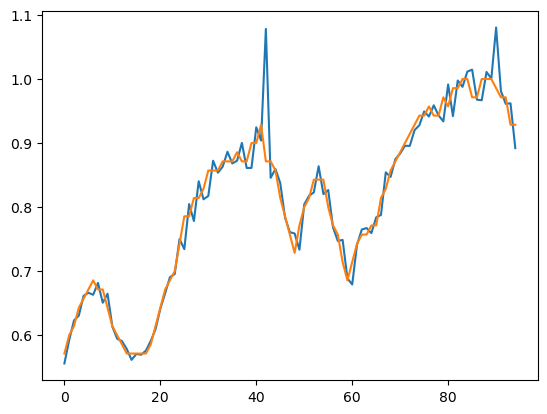

In [ ]:
num_predict = 5
n_value = 1
model_path = f"model_Taylor_1st_5_mins.pth"

model = Taylor_Net(n=n_value).to(device)
model.load_state_dict(torch.load(model_path))
t_next = calculate_next(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
plt.plot(t_next.to("cpu").detach().numpy())
plt.plot(output__t[:-num_predict].to("cpu").detach().numpy())
r2_Tay, out_Tay, real_Tay = evaluate_model_1(model_path, model_class=Taylor_Net, num_predict=num_predict, device=device)

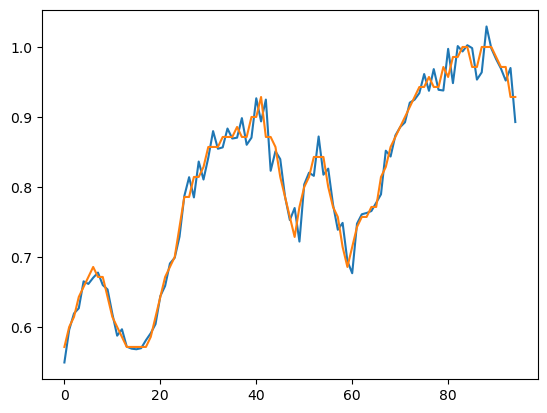

In [ ]:
model_path = f"model_Mono_Taylor_1st_5_mins.pth"
n_value = 1
model = Taylor_Mono_Net(n=n_value).to(device)
model.load_state_dict(torch.load(model_path))
t_next = calculate_next(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
plt.plot(t_next.to("cpu").detach().numpy())
plt.plot(output__t[:-num_predict].to("cpu").detach().numpy())
r2_Mono, out_Mono, real_Mono = evaluate_model_1(model_path, model_class=Taylor_Mono_Net, num_predict=num_predict, device=device)

In [ ]:
# Modify train_model to accept scheduler
def train_model_2(model, optimizer, criterion, temp_cur_tr, temp_tr, supply_tr, air_tr, output_temp_tr, delta_tr, scheduler=None, epochs=20000, patience=1000, threshold=1e-10, print_interval=5000):
    prev_loss = float('inf')
    no_improvement_counter = 0
    loss_array = []
    r2_array = []
    last_loss = 0
    point = []
    for epoch in range(epochs):
        model.train()  
        optimizer.zero_grad()
        elementwise_product = torch.mul(model(temp_tr, supply_tr, air_tr), delta_tr)
        c = model(temp_tr, supply_tr, air_tr)

        dot_products = torch.sum(elementwise_product, dim=1, keepdim=True)
        output = temp_cur_tr + dot_products
    
        grad_outputs = torch.ones_like(c)[:, 0]
        dc_dx_dx = torch.autograd.grad(outputs=c[:, 0], inputs=temp_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dx_dy = torch.autograd.grad(outputs=c[:, 0], inputs=supply_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dx_dz = torch.autograd.grad(outputs=c[:, 0], inputs=air_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        
        dc_dy_dy = torch.autograd.grad(outputs=c[:, 1], inputs=supply_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dy_dx = torch.autograd.grad(outputs=c[:, 1], inputs=temp_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dy_dz = torch.autograd.grad(outputs=c[:, 1], inputs=air_tr, grad_outputs=grad_outputs, retain_graph=True)[0]

        
        dc_dz_dz = torch.autograd.grad(outputs=c[:, 2], inputs=air_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dz_dx = torch.autograd.grad(outputs=c[:, 2], inputs=temp_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dz_dy = torch.autograd.grad(outputs=c[:, 2], inputs=supply_tr, grad_outputs=grad_outputs, retain_graph=True)[0]

        dx = delta_tr[:, 0].reshape(-1,1)
        dy = delta_tr[:, 1].reshape(-1,1)
        dz = delta_tr[:, 2].reshape(-1,1)
        t_next = output + (dc_dx_dx*dx**2 + dc_dy_dy*dy**2 + dc_dz_dz*dz**2 + (dc_dx_dy + dc_dy_dx)*dx*dy + (dc_dx_dz + dc_dz_dx)*dx*dz + (dc_dy_dz+dc_dz_dy)*dy*dz) / 2

        loss = criterion(t_next, output_temp_tr)
        loss_array.append(loss.item())

        loss.backward(retain_graph=True)
        optimizer.step()
        if scheduler:
            scheduler.step()
        if epoch % 50 ==0:
            r2_score_val = r2_score(output_temp_tr.to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
            r2_array.append(r2_score_val)
            point.append(epoch // 50)
        if epoch % print_interval == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.9f}')
        if abs(prev_loss - loss.item()) < threshold:
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0  
        
        prev_loss = loss.item()
        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no significant improvement.')
            break
        if loss.item() < 0.0000075052:
            print(f'Early stopping at epoch {epoch+1} due to very low loss.')
            print("min of loss function is", min(loss_array))
            break
    
    return loss.item()

In [ ]:
def calculate_next_2(model, temp_cur__t, temp__t, supply__t, air__t, delta__t):
    temp__t = temp__t.requires_grad_(True)
    supply__t = supply__t.requires_grad_(True)
    air__t = air__t.requires_grad_(True)
    elementwise_product__t = torch.mul(model(temp__t, supply__t, air__t), delta__t)
    c = model(temp__t, supply__t, air__t)
    dot_products__t = torch.sum(elementwise_product__t, dim=1, keepdim=True)
    output_temp__t = temp_cur__t + dot_products__t
    grad_outputs = torch.ones_like(c)[:, 0]
    dc_dx_dx = torch.autograd.grad(outputs=c[:, 0], inputs=temp__t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dx_dy = torch.autograd.grad(outputs=c[:, 0], inputs=supply__t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dx_dz = torch.autograd.grad(outputs=c[:, 0], inputs=air__t, grad_outputs=grad_outputs, retain_graph=True)[0]
        
    dc_dy_dy = torch.autograd.grad(outputs=c[:, 1], inputs=supply__t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dy_dx = torch.autograd.grad(outputs=c[:, 1], inputs=temp__t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dy_dz = torch.autograd.grad(outputs=c[:, 1], inputs=air__t, grad_outputs=grad_outputs, retain_graph=True)[0]
   
    dc_dz_dz = torch.autograd.grad(outputs=c[:, 2], inputs=air__t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dz_dx = torch.autograd.grad(outputs=c[:, 2], inputs=temp__t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dz_dy = torch.autograd.grad(outputs=c[:, 2], inputs=supply__t, grad_outputs=grad_outputs, retain_graph=True)[0]

    dx = delta__t[:, 0].reshape(-1,1)
    dy = delta__t[:, 1].reshape(-1,1)
    dz = delta__t[:, 2].reshape(-1,1)
        
    t_next = output_temp__t + (dc_dx_dx*dx**2 + dc_dy_dy*dy**2 + dc_dz_dz*dz**2 + (dc_dx_dy + dc_dy_dx)*dx*dy + (dc_dx_dz + dc_dz_dx)*dx*dz + (dc_dy_dz+dc_dz_dy)*dy*dz) / 2
    return t_next

In [ ]:
learning = np.arange(0.0001, 0.01, 0.0002)
num__t = 1
current_mse_score = 0
mse = []
mse.append(0.000287086)
for lr in learning:
    for i in range(num__t):
        n_value = 1
        model_path = f"model_Taylor_1st_5_mins.pth"
        model_Taylor = Taylor_Net(n=n_value).to(device)
        model_Taylor.load_state_dict(torch.load(model_path))
        optimizer = optim.Adam(model_Taylor.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=decay_step_size, gamma=decay_factor)
    
        loss_Tay = train_model_2(
            model=model_Taylor,
            optimizer=optimizer,
            criterion=nn.MSELoss(),
            temp_cur_tr= temp_cur_tr,
            temp_tr=temp_tr,
            supply_tr=supply_tr,
            air_tr=air_tr,
            output_temp_tr=output_tr,
            delta_tr=delta_tr,
            scheduler=scheduler, 
            epochs=20000,
            patience=patience,
            threshold=threshold,
            print_interval=5000
        )
        if loss_Tay < 10.1:
            t_next__t = calculate_next_2(model_Taylor, temp_cur_val, temp_val, supply_val, air_val, delta_val)
            current_mse_score = mean_squared_error(output_val.to("cpu").detach().numpy(), t_next__t.to("cpu").detach().numpy())
            if current_mse_score > -10:
                if current_mse_score < min(mse):
                    torch.save(model_Taylor.state_dict(), f"model_Taylor_2nd_convex_5_mins.pth")
                    mse.append(current_mse_score)
                    print(current_mse_score)

In [ ]:
learning = np.arange(0.001, 0.1, 0.002)
num__t = 1
current_mse_score = 0
mse = []
mse.append(1)
for lr in learning:
    for i in range(num__t):
        # Train model_Taylor
        n_value = 1
        model_path = f"model_Mono_Taylor_1st_5_mins.pth"
        model_Taylor_Mono = Taylor_Mono_Net(n=n_value).to(device)
        model_Taylor_Mono.load_state_dict(torch.load(model_path))
        optimizer = optim.Adam(model_Taylor.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=decay_step_size, gamma=decay_factor)
    
        loss_Tay = train_model_2(
            model=model_Taylor_Mono,
            optimizer=optimizer,
            criterion=nn.MSELoss(),
            temp_cur_tr= temp_cur_tr,
            temp_tr=temp_tr,
            supply_tr=supply_tr,
            air_tr=air_tr,
            output_temp_tr=output_tr,
            delta_tr=delta_tr,
            scheduler=scheduler, 
            epochs=20000,
            patience=patience,
            threshold=threshold,
            print_interval=10000
        )
        if loss_Tay < 10.1:
            t_next__t = calculate_next_2(model_Taylor_Mono, temp_cur_val, temp_val, supply_val, air_val, delta_val)
            current_mse_score = mean_squared_error(output_val.to("cpu").detach().numpy(), t_next__t.to("cpu").detach().numpy())
            if current_mse_score > -10:
                if current_mse_score < min(mse):
                    torch.save(model_Taylor_Mono.state_dict(), f"model_Mono_Taylor_2nd_convex_5_mins.pth")
                    mse.append(current_mse_score)
                    print(current_mse_score)

In [ ]:
def evaluate_model_1(model_path, model_class, num_predict, device='cpu'):
    r2_loop = []
    output_loop = []
    real_loop = []
    model = model_class(n=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    t_next = calculate_next(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
    r2 = r2_score(output__t[:-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    output_loop.append(t_next.to("cpu").detach().numpy())
    real_loop.append(output__t[:-num_predict].to("cpu").detach().numpy())
    
    thresh = 1
    delta = t_next - temp_cur__t[0:-num_predict]
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[1:1-num_predict, 1].reshape(-1,1), delta__t[1:1-num_predict, 2].reshape(-1,1)), dim = 1)
    
    t_next_2 = calculate_next(model, t_next, temp__t[1:1-num_predict], supply__t[1:1-num_predict], air__t[1:1-num_predict], delta)
    r2 = r2_score(output__t[1:1-num_predict].to("cpu").detach().numpy(), t_next_2.to("cpu").detach().numpy())
    r2_loop.append(r2)
    output_loop.append(t_next_2.to("cpu").detach().numpy())
    real_loop.append(output__t[1:1-num_predict].to("cpu").detach().numpy())
    delta = t_next_2 - t_next
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[2:2-num_predict, 1].reshape(-1,1), delta__t[2:2-num_predict, 2].reshape(-1,1)), dim = 1)
    
    for i in range(2, num_predict):
        t_next_3 = calculate_next(model, t_next_2, t_next, supply__t[i:i-num_predict], air__t[i:i-num_predict], delta)
        r2 = r2_score(output__t[i:i-num_predict].to("cpu").detach().numpy(), t_next_3.to("cpu").detach().numpy())
        r2_loop.append(r2)
        output_loop.append(t_next_3.to("cpu").detach().numpy())
        real_loop.append(output__t[i:i-num_predict].to("cpu").detach().numpy())
        delta = t_next_3 - t_next_2
        delta = torch.clamp(delta, max=thresh, min = -thresh) 
        if i < num_predict-1:
            delta = torch.cat((delta, delta__t[1+i:1+i-num_predict, 1].reshape(-1,1), delta__t[1+i:1+i-num_predict, 2].reshape(-1,1)), dim = 1)
            t_next = t_next_2
            t_next_2 = t_next_3
    return r2_loop, output_loop, real_loop

In [ ]:
def evaluate_model_2(model_path, model_class, num_predict, device='cpu'):
    r2_loop = []
    output_loop = []
    real_loop = []
    model = model_class(n=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    t_next = calculate_next_2(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
    r2 = r2_score(output__t[:-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    output_loop.append(t_next.to("cpu").detach().numpy())
    real_loop.append(output__t[:-num_predict].to("cpu").detach().numpy())
    thresh = 1
    delta = t_next - temp_cur__t[0:-num_predict]
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[1:1-num_predict, 1].reshape(-1,1), delta__t[1:1-num_predict, 2].reshape(-1,1)), dim = 1)
    
    t_next_2 = calculate_next_2(model, t_next, temp__t[1:1-num_predict], supply__t[1:1-num_predict], air__t[1:1-num_predict], delta)
    r2 = r2_score(output__t[1:1-num_predict].to("cpu").detach().numpy(), t_next_2.to("cpu").detach().numpy())
    r2_loop.append(r2)
    output_loop.append(t_next_2.to("cpu").detach().numpy())
    real_loop.append(output__t[1:1-num_predict].to("cpu").detach().numpy())
    delta = t_next_2 - t_next
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[2:2-num_predict, 1].reshape(-1,1), delta__t[2:2-num_predict, 2].reshape(-1,1)), dim = 1)
    
    for i in range(2, num_predict):
        t_next_3 = calculate_next_2(model, t_next_2, t_next, supply__t[i:i-num_predict], air__t[i:i-num_predict], delta)
        r2 = r2_score(output__t[i:i-num_predict].to("cpu").detach().numpy(), t_next_3.to("cpu").detach().numpy())
        r2_loop.append(r2)
        output_loop.append(t_next_3.to("cpu").detach().numpy())
        real_loop.append(output__t[i:i-num_predict].to("cpu").detach().numpy())
        delta = t_next_3 - t_next_2
        delta = torch.clamp(delta, max=thresh, min = -thresh) 
        if i < num_predict-1:
            delta = torch.cat((delta, delta__t[1+i:1+i-num_predict, 1].reshape(-1,1), delta__t[1+i:1+i-num_predict, 2].reshape(-1,1)), dim = 1)
            t_next = t_next_2
            t_next_2 = t_next_3
    return r2_loop, output_loop, real_loop

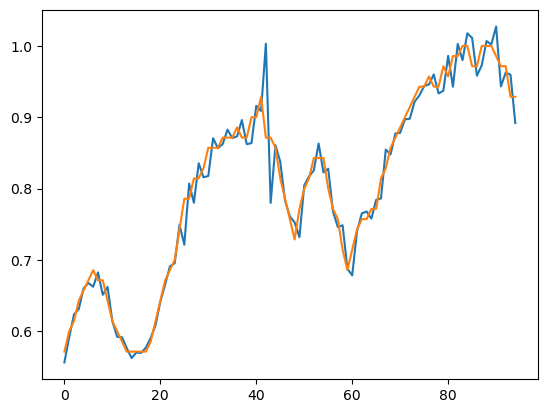

In [ ]:
n_value = 1
model_path = f"model_Taylor_2nd_5_mins.pth"

model = Taylor_Net(n=n_value).to(device)
model.load_state_dict(torch.load(model_path))
t_next = calculate_next_2(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
plt.plot(t_next.to("cpu").detach().numpy())
plt.plot(output__t[:-num_predict].to("cpu").detach().numpy())
r2_2_Tay, out_2_Tay, real_2_Tay = evaluate_model_2(model_path, model_class=Taylor_Net, num_predict=num_predict, device=device)

[0.9764598380471567,
 0.9531536113282675,
 0.9433416559593093,
 0.9097932862150407,
 0.9072747922398793,
 0.8874355341681319,
 0.8582834876013758]

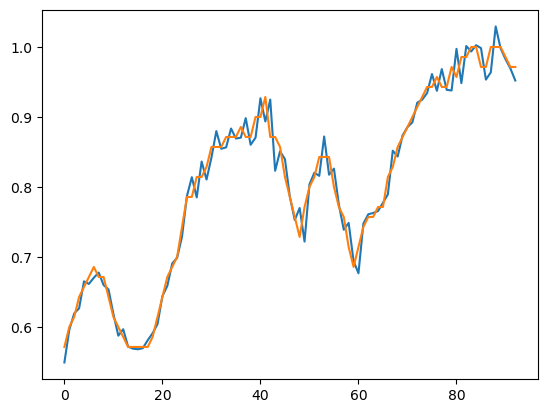

In [ ]:
model_path = f"model_Mono_Taylor_1st_5_mins.pth"
n_value = 1
model = Taylor_Mono_Net(n=n_value).to(device)
model.load_state_dict(torch.load(model_path))
t_next = calculate_next(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
plt.plot(t_next.to("cpu").detach().numpy())
plt.plot(output__t[:-num_predict].to("cpu").detach().numpy())
evaluate_model_1(model_path, model_class=Taylor_Mono_Net, num_predict=num_predict, device=device)

[0.9765131006945814,
 0.9532133805633268,
 0.9435350493988518,
 0.9100172742530217,
 0.9076855641771302,
 0.8879602342590829,
 0.8591737145223456]

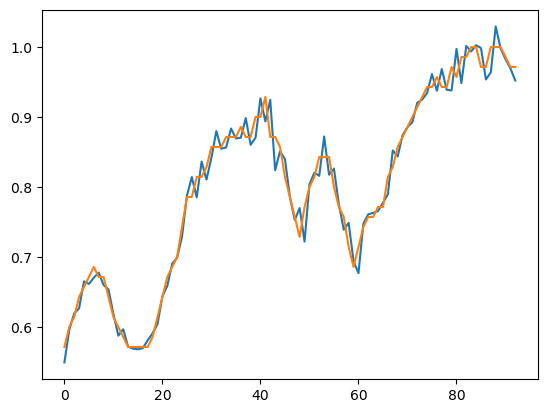

In [ ]:
model_path = f"model_Mono_Taylor_2nd_5_mins.pth"
n_value = 1
model = Taylor_Mono_Net(n=n_value).to(device)
model.load_state_dict(torch.load(model_path))
t_next = calculate_next_2(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
plt.plot(t_next.to("cpu").detach().numpy())
plt.plot(output__t[:-num_predict].to("cpu").detach().numpy())
evaluate_model_2(model_path, model_class=Taylor_Mono_Net, num_predict=num_predict, device=device)

In [ ]:
def rmse_model_1(model_path, model_class, num_predict, device='cpu'):
    r2_loop = []
    model = model_class(n=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    t_next = calculate_next(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
    r2 = mean_squared_error(output__t[:-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    thresh = 1
    delta = t_next - temp_cur__t[0:-num_predict]
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[1:1-num_predict, 1].reshape(-1,1), delta__t[1:1-num_predict, 2].reshape(-1,1)), dim = 1)
    
    t_next_2 = calculate_next(model, t_next, temp__t[1:1-num_predict], supply__t[1:1-num_predict], air__t[1:1-num_predict], delta)
    r2 = mean_squared_error(output__t[1:1-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    delta = t_next_2 - t_next
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[2:2-num_predict, 1].reshape(-1,1), delta__t[2:2-num_predict, 2].reshape(-1,1)), dim = 1)
    
    for i in range(2, num_predict):
        t_next_3 = calculate_next(model, t_next_2, t_next, supply__t[i:i-num_predict], air__t[i:i-num_predict], delta)
        r2 = mean_squared_error(output__t[i:i-num_predict].to("cpu").detach().numpy(), t_next_3.to("cpu").detach().numpy())
        r2_loop.append(r2)
        delta = t_next_3 - t_next_2
        delta = torch.clamp(delta, max=thresh, min = -thresh) 
        if i < num_predict-1:
            delta = torch.cat((delta, delta__t[1+i:1+i-num_predict, 1].reshape(-1,1), delta__t[1+i:1+i-num_predict, 2].reshape(-1,1)), dim = 1)
            t_next = t_next_2
            t_next_2 = t_next_3
    return np.sqrt(r2_loop).reshape(-1,1)*7

In [ ]:
def rmse_model_2(model_path, model_class, num_predict, device='cpu'):
    r2_loop = []
    model = model_class(n=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    t_next = calculate_next_2(model, temp_cur__t[0:-num_predict], temp__t[0:-num_predict], supply__t[0:-num_predict], air__t[0:-num_predict], delta__t[0:-num_predict])
    r2 = mean_squared_error(output__t[:-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    thresh = 1
    delta = t_next - temp_cur__t[0:-num_predict]
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[1:1-num_predict, 1].reshape(-1,1), delta__t[1:1-num_predict, 2].reshape(-1,1)), dim = 1)
    
    t_next_2 = calculate_next_2(model, t_next, temp__t[1:1-num_predict], supply__t[1:1-num_predict], air__t[1:1-num_predict], delta)
    r2 = mean_squared_error(output__t[1:1-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    delta = t_next_2 - t_next
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta__t[2:2-num_predict, 1].reshape(-1,1), delta__t[2:2-num_predict, 2].reshape(-1,1)), dim = 1)
    
    for i in range(2, num_predict):
        t_next_3 = calculate_next_2(model, t_next_2, t_next, supply__t[i:i-num_predict], air__t[i:i-num_predict], delta)
        r2 = mean_squared_error(output__t[i:i-num_predict].to("cpu").detach().numpy(), t_next_3.to("cpu").detach().numpy())
        r2_loop.append(r2)
        delta = t_next_3 - t_next_2
        delta = torch.clamp(delta, max=thresh, min = -thresh) 
        if i < num_predict-1:
            delta = torch.cat((delta, delta__t[1+i:1+i-num_predict, 1].reshape(-1,1), delta__t[1+i:1+i-num_predict, 2].reshape(-1,1)), dim = 1)
            t_next = t_next_2
            t_next_2 = t_next_3
    return np.sqrt(r2_loop).reshape(-1,1)*7

In [ ]:
num_predict = 7
n_value = 1
model_path = f"model_Taylor_1st_5_mins.pth"

model = Taylor_Net(n=n_value).to(device)
model.load_state_dict(torch.load(model_path))
rmse_model_1(model_path, model_class=Taylor_Net, num_predict=num_predict, device=device)

array([[0.21164906],
       [0.2575375 ],
       [0.49002087],
       [0.62314606],
       [0.7273983 ],
       [0.84345907],
       [0.9633661 ]], dtype=float32)

In [ ]:
model_path = f"model_Mono_Taylor_1st_5_mins.pth"
n_value = 1
model = Taylor_Mono_Net(n=n_value).to(device)
model.load_state_dict(torch.load(model_path))
rmse_model_1(model_path, model_class=Taylor_Mono_Net, num_predict=num_predict, device=device)

array([[0.13967898],
       [0.19458966],
       [0.21197677],
       [0.26493627],
       [0.26621658],
       [0.29089648],
       [0.32395405]], dtype=float32)

In [ ]:
n_value = 1
model_path = f"model_Taylor_2nd_5_mins.pth"

model = Taylor_Net(n=n_value).to(device)
model.load_state_dict(torch.load(model_path))
rmse_model_2(model_path, model_class=Taylor_Net, num_predict=num_predict, device=device)

array([[0.17741188],
       [0.23050232],
       [0.31990692],
       [0.3768813 ],
       [0.41527647],
       [0.4705177 ],
       [0.53776914]], dtype=float32)

In [ ]:
model_path = f"model_Mono_Taylor_2nd_5_mins.pth"
n_value = 1
model = Taylor_Mono_Net(n=n_value).to(device)
model.load_state_dict(torch.load(model_path))
rmse_model_2(model_path, model_class=Taylor_Mono_Net, num_predict=num_predict, device=device)

array([[0.13952085],
       [0.19446549],
       [0.21161467],
       [0.26460713],
       [0.26562622],
       [0.29021773],
       [0.32293496]], dtype=float32)

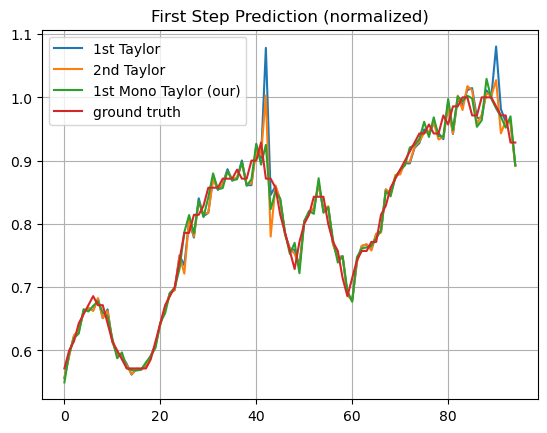

In [194]:
plt.plot(out_Tay[0], label="1st Taylor")
plt.plot(out_2_Tay[0], label="2nd Taylor")
plt.plot(out_Mono[0], label="1st Mono Taylor (our)")
plt.plot(real_Mono[0], label="ground truth")
plt.grid(True)
plt.title("First Step Prediction (normalized)")
plt.legend()
plt.show()

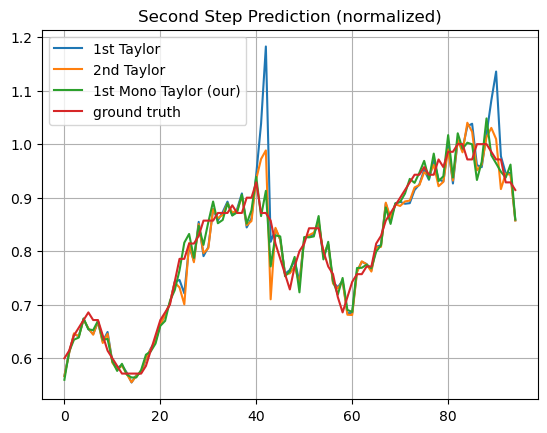

In [196]:
plt.plot(out_Tay[1], label="1st Taylor")
plt.plot(out_2_Tay[1], label="2nd Taylor")
plt.plot(out_Mono[1], label="1st Mono Taylor (our)")
plt.plot(real_Mono[1], label="ground truth")
plt.grid(True)
plt.title("Second Step Prediction (normalized)")
plt.legend()
plt.show()

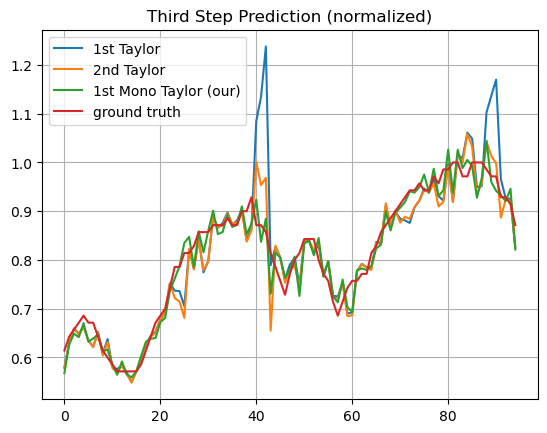

In [198]:
plt.plot(out_Tay[2], label="1st Taylor")
plt.plot(out_2_Tay[2], label="2nd Taylor")
plt.plot(out_Mono[2], label="1st Mono Taylor (our)")
plt.plot(real_Mono[2], label="ground truth")
plt.grid(True)
plt.title("Third Step Prediction (normalized)")
plt.legend()
plt.show()

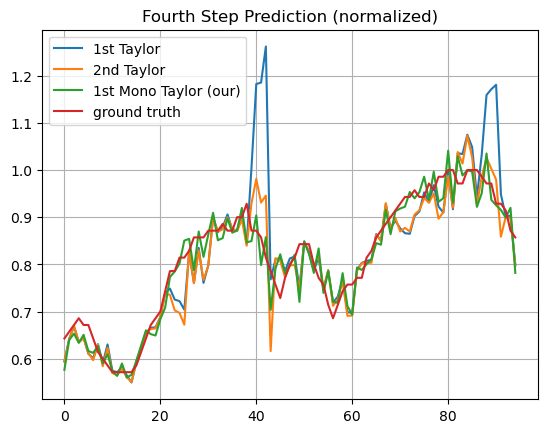

In [200]:
plt.plot(out_Tay[3], label="1st Taylor")
plt.plot(out_2_Tay[3], label="2nd Taylor")
plt.plot(out_Mono[3], label="1st Mono Taylor (our)")
plt.plot(real_Mono[3], label="ground truth")
plt.grid(True)
plt.title("Fourth Step Prediction (normalized)")
plt.legend()
plt.show()

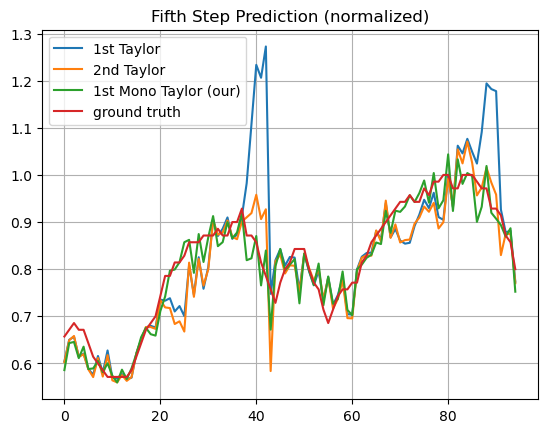

In [202]:
plt.plot(out_Tay[4], label="1st Taylor")
plt.plot(out_2_Tay[4], label="2nd Taylor")
plt.plot(out_Mono[4], label="1st Mono Taylor (our)")
plt.plot(real_Mono[4], label="ground truth")
plt.grid(True)
plt.title("Fifth Step Prediction (normalized)")
plt.legend()
plt.show()